# 손실 곡선

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [ ]:
model = model_fn()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


## history 객체
 - 훈련 측정값이 담겨 있음
 - compile() 메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 history 속성에 포함됨

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


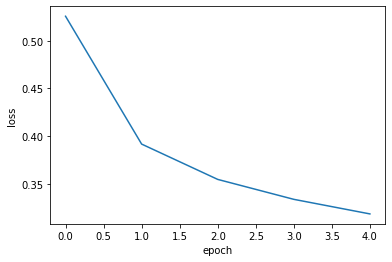

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

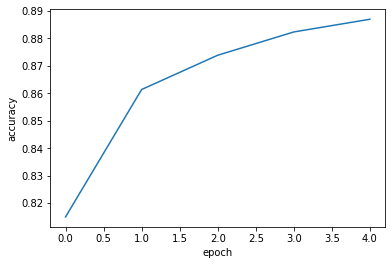

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크마다 손실이 감소하고 정확도가 향상하는 것을 볼 수 있다

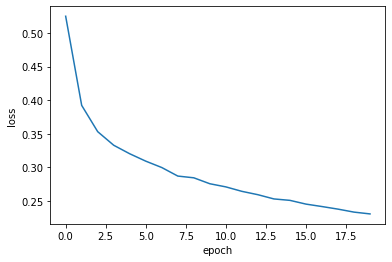

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


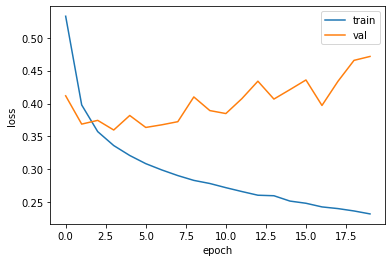

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 감소하다가 다섯 번째 에포크 만에 다시 상승 -> 전형적인 과대적합 모델

# Adam 옵티마이저 적용
- 과대적합을 막기 위해
- Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크리를 조정할 수 있음

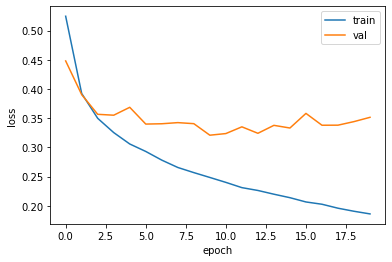

In [ ]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 줄은 것을 볼 수 있다

## 드롭아웃
 - dropout
 - 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법
 - 훈련 중에 적용되며 평가나 예측에서는 적용하지 않는다
 - 이전 층의 일부 뉴런이 핸덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄 일 수 있음

30% 정도를 드롭아웃

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


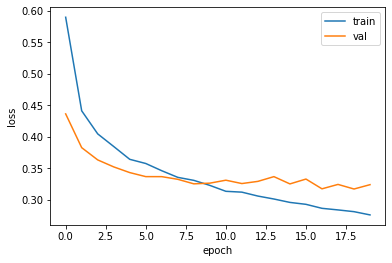

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다

## 모델 저장과 복원

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

## 1) save_weights

In [ ]:
model.save_weights('model-weights.h5')

In [ ]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jan 15 11:26 model-weights.h5


In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [ ]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8795


## 2) save

In [ ]:
model.save('model-whole.h5')

In [ ]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jan 15 11:26 model-weights.h5
-rw-r--r-- 1 root root 334816 Jan 15 11:26 model-whole.h5


In [ ]:
model = keras.models.load_model('model-whole.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3278 - accuracy: 0.8795


[0.32775139808654785, 0.8794999718666077]

## 콜백
 - callback
 - 케라스 모델을 훈련하는 도중에 어떤 작업을 수행할 수 있도록 도와주는 도구
 - 대표적으로 최상의 모델을 자동으로 저장해 주거나 검증 점수가 더 이상 향상되지 않으면 일찍 종료할 수 있음

**ModelCheckpoint 콜백**
 - 기본적으로 에포크마다 모델을 저장
 - save_best_only=True : 가장 낮은 검증 점수를 만드는 모델을 저장

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

 - load_model()

In [ ]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3190 - accuracy: 0.8871


[0.31900444626808167, 0.8870833516120911]

## 조기 종료
 - early stopping
 - 과대적합이 시작되기 전에 훈련을 미리 중지하는 것
 - 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합되는 것을 막아 주기 때문에 규제 방법으로 여길 수 있음

**EarlyStopping 콜백**
- patience 매개변수 : 검증 검수가 향상되지 않더라도 참을 에포크 횟수를 지정
- restore_best_weights 매개변수 : True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

EarlyStopping 콜백읠 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈현을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [ ]:
print(early_stopping_cb.stopped_epoch)

0


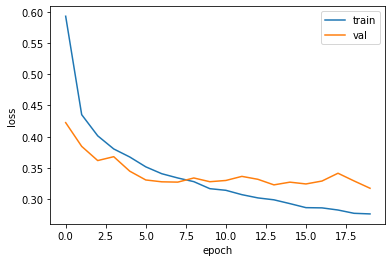

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3174 - accuracy: 0.8875


[0.3173605799674988, 0.887499988079071]